In [14]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

## Combine All 3 Datasets

In [ ]:
path = '../dataset/'

# Load and tag source
df1 = pd.read_csv(path+"ElBorn.csv")
df1["District"] = "ElBorn"

df2 = pd.read_csv(path+"LesCorts.csv")
df2["District"] = "LesCorts"

df3 = pd.read_csv(path+"PobleSec.csv")
df3["District"] = "PobleSec"

# Combine
df_all = pd.concat([df1, df2, df3], ignore_index=True)
print(f"Combined shape: {df_all.shape}")
df_all.head(2)

Combined shape: (27011, 13)


,time,down,up,rnti_count,mcs_down,mcs_down_var,mcs_up,mcs_up_var,rb_down,rb_down_var,rb_up,rb_up_var,District
0,2018-03-28 15:56:00,174876888.0,1856888.0,10229,15.332298,87.157688,14.981497,49.989484,0.029681,4.497698e-08,0.000541,3.143297e-08,ElBorn
1,2018-03-28 15:58:00,209054184.0,2866200.0,12223,15.116846,87.192168,16.432612,62.494670,0.035971,4.615535e-08,0.000852,4.439640e-08,ElBorn


## Preprocess for Clustering

In [ ]:
# Drop non-numeric + time column
features = df_all.drop(columns=["time", "District"])

# Fill NA values
features = features.fillna(features.mean())

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

## Determine Optimal Clusters

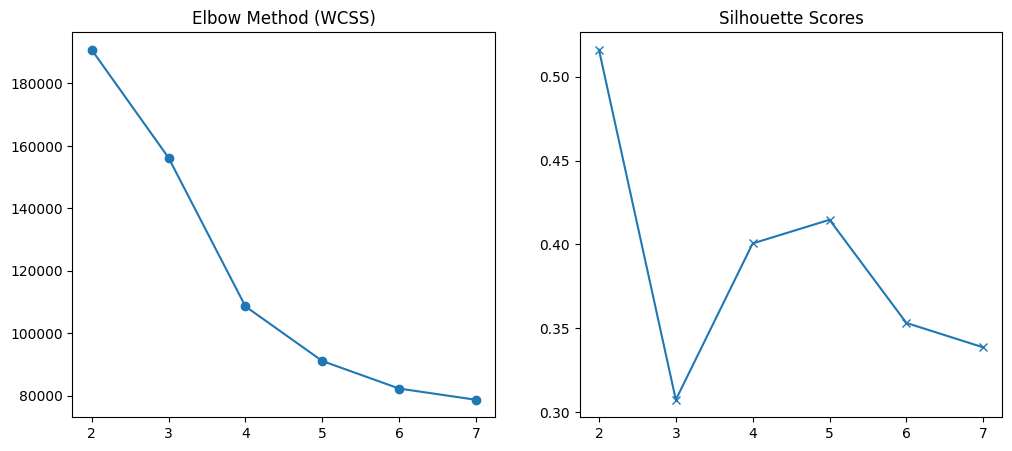

In [ ]:
# Calculate WCSS (Within-Cluster Sum of Squares) and Silhouette Scores for different cluster counts
wcss = [] # List to store WCSS for each k
silhouette_scores = [] # List to store silhouette scores for each k

for k in range(2, 8):
    model = KMeans(n_clusters=k, random_state=42)
    preds = model.fit_predict(X_scaled)
    wcss.append(model.inertia_) # Inertia is the WCSS for current k
    silhouette_scores.append(silhouette_score(X_scaled, preds)) # How well clusters are separated

# Plot the Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))

# Elbow Method plot: helps to visually determine the optimal number of clusters (look for the "elbow")
plt.subplot(1, 2, 1)
plt.plot(range(2, 8), wcss, marker='o')
plt.title('Elbow Method (WCSS)')

# Silhouette Score plot: higher values mean better-defined clusters
plt.subplot(1, 2, 2)
plt.plot(range(2, 8), silhouette_scores, marker='x')
plt.title('Silhouette Scores')
plt.show()

## Run Different Clustering Algorithms

In [ ]:
# Define a dictionary of clustering models to compare
models = {
    "KMeans": KMeans(n_clusters=3, random_state=42),        
    "DBSCAN": DBSCAN(eps=1.5, min_samples=5),
    "Hierarchical": AgglomerativeClustering(n_clusters=3)
}

# Fit each clustering model and store the resulting cluster labels in the dataframe
for name, model in models.items():
    labels = model.fit_predict(X_scaled)
    df_all[f"{name}_Cluster"] = labels

## Evaluate Clustering Results

In [ ]:
# Calculate and print clustering metrics for each model
for name in models.keys():
    labels = df_all[f"{name}_Cluster"]
    if len(set(labels)) > 1:
        print(f"\n🔍 {name} Clustering:")
        print("Silhouette Score:", silhouette_score(X_scaled, labels))
        print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, labels))
    else:
        print(f"\n⚠️ {name} returned only 1 cluster — skipping metrics.")


🔍 KMeans Clustering:
Silhouette Score: 0.30731833921170776
Calinski-Harabasz Index: 12179.118701048717

🔍 DBSCAN Clustering:
Silhouette Score: 0.351636930296241
Calinski-Harabasz Index: 508.6383914277296

🔍 Hierarchical Clustering:
Silhouette Score: 0.4741353649159934
Calinski-Harabasz Index: 13761.164873967735


## Cluster Evaluation Summary

| Algorithm        | Silhouette Score ↑ | Calinski-Harabasz ↑ | Remarks                                                                 |
| ---------------- | ------------------ | ------------------- | ----------------------------------------------------------------------- |
| **KMeans**       | 0.31               | 12,179              | Acceptable clusters but not very distinct.                              |
| **DBSCAN**       | 0.35               | 508                 | Found dense clusters, but possibly many outliers or fewer valid points. |
| **Hierarchical** | **0.47** ✅         | **13,761** ✅        | Best overall cluster separation and compactness.                        |


`Interpretation`

- Silhouette Score (0–1):
    - Measures how well each point fits in its cluster (higher is better).
    - 0.4 usually indicates reasonably well-formed clusters.

- Calinski-Harabasz:
    - Higher means better cluster separation vs. within-cluster compactness.
    - Best seen comparatively across methods.

## Visualize Clusters (PCA & t-SNE)

In [15]:
# Use the best cluster result
features = df_all.drop(columns=["time", "District", "KMeans_Cluster", "DBSCAN_Cluster"])  # Kept Hierarchical_Cluster

X = features.select_dtypes(include=[float, int]).fillna(0).values
labels = df_all["Hierarchical_Cluster"]

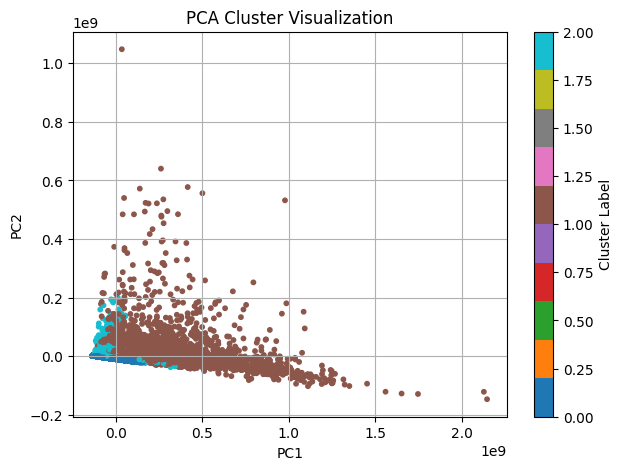

In [19]:
# PCA Visualization
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

plt.figure(figsize=(7, 5))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.title("PCA Cluster Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

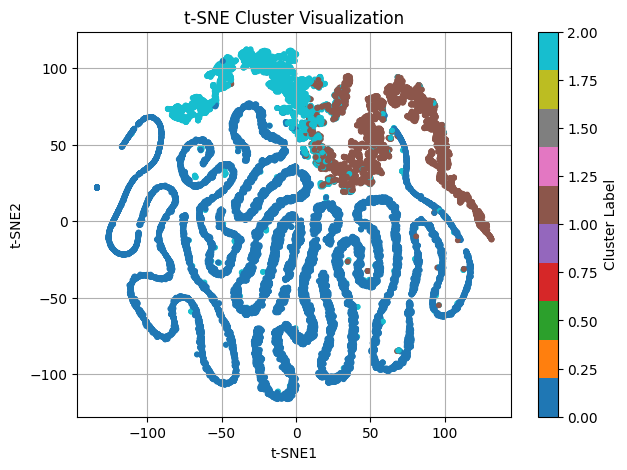

In [20]:
# t-SNE Visualization (slower)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_2d = tsne.fit_transform(X)

plt.figure(figsize=(7, 5))
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.title("t-SNE Cluster Visualization")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

`Interpretation`

| Visualization               | Insights                                         | Verdict     |
| --------------------------- | ------------------------------------------------ | ----------- |
| **PCA**                     | Shows some spread but unclear cluster separation | Moderate    |
| **t-SNE**                   | Shows clear grouping of clusters                 | ✅ Excellent |
| **Hierarchical Clustering** | Confirmed as best algorithm for this data        | ✔️ Use it   |


## Add Cluster as Feature for LSTM

In [23]:
# Convert cluster column to numeric type
df_all["Hierarchical_Cluster"] = df_all["Hierarchical_Cluster"].astype(int)

# Add to main features
df_all["Cluster_Feature"] = df_all["Hierarchical_Cluster"]

df_all = df_all.drop(columns=["KMeans_Cluster", "DBSCAN_Cluster", "Hierarchical_Cluster"])  # Keep only Hierarchical_Cluster

# Save and use in prepare_dataset
df_all.to_csv(path+"combined_with_cluster_feature.csv", index=False)

In [24]:
df_all.head(2)

,time,down,up,rnti_count,mcs_down,mcs_down_var,mcs_up,mcs_up_var,rb_down,rb_down_var,rb_up,rb_up_var,District,Cluster_Feature
0,2018-03-28 15:56:00,174876888.0,1856888.0,10229,15.332298,87.157688,14.981497,49.989484,0.029681,4.497698e-08,0.000541,3.143297e-08,ElBorn,0
1,2018-03-28 15:58:00,209054184.0,2866200.0,12223,15.116846,87.192168,16.432612,62.494670,0.035971,4.615535e-08,0.000852,4.439640e-08,ElBorn,0
